In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
from statsmodels.datasets import get_rdataset
from theano import tensor as tt

In [4]:
blue, *_ = sns.color_palette()
SEED = 5132290 #from random.org
np.random.seed(SEED)
N = 20
K = 30
alpha = 2.
P0 = sp.stats.norm


In [5]:
#Draw samples from the stick breaking process
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:,0] = beta[:,0]
w[:,1:] = beta[:,1:] * (1 - beta[:, :-1]).cumprod(axis=1)
omega = P0.rvs(size=(N,K))
x_plot = np.linspace(-3, 3, 200)
sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

In [20]:
beta.shape, w.shape, sample_cdfs.shape, omega.shape

((20, 30), (20, 30), (20, 200), (20, 30))

In [23]:
np.less.outer(omega, x_plot).shape

(20, 30, 200)

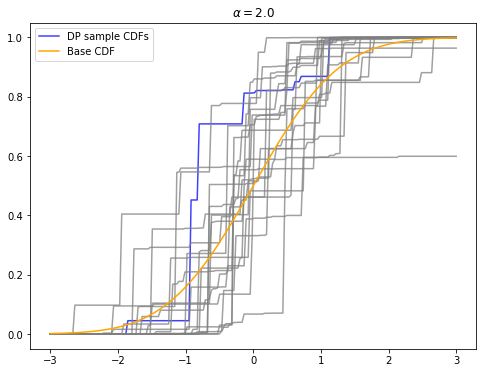

In [11]:
#Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_plot, sample_cdfs[0], c='blue', alpha=0.75, label='DP sample CDFs')
ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75)
ax.plot(x_plot, P0.cdf(x_plot), c='orange', label='Base CDF')
ax.set_title(r'$\alpha={}$'.format(alpha))
ax.legend(loc=2)